# Corrected overfitting issue

In [1]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from joblib import dump

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
data = pd.read_excel("Extruder_model.xlsx")
data

,mass_flow(kg/h),screw_speed(rpm),solid_content(%),Energy(kJ/kg),Torque(N.m)
0,2.28,800,70.0,6552.149619,2.972000
1,2.28,1000,70.0,9031.174828,3.277172
2,2.28,1200,70.0,8612.666192,2.604422
3,4.56,800,70.0,3868.788613,3.509700
4,4.56,1000,70.0,4463.403908,3.239300
...,...,...,...,...,...
63,6.84,1000,85.0,8257.584290,8.989370
64,6.84,1200,85.0,10161.012782,9.217900
65,9.13,1200,85.0,8098.660981,9.806700
66,11.41,1200,85.0,6704.428438,10.145800


In [3]:
data = pd.read_excel("Extruder_model.xlsx")
data = data.sample(frac=1)
X_data = data.drop(["Energy(kJ/kg)" , "Torque(N.m)"],axis=1)
Y_data = data["Energy(kJ/kg)"].values
scaler = MinMaxScaler()
X_data = scaler.fit_transform(X_data)
dump(scaler , "scaler.joblib")

['scaler.joblib']

In [4]:
X_data

array([[0.4       , 0.5       , 0.33333333],
       [0.60087719, 0.        , 0.        ],
       [0.4       , 0.5       , 0.66666667],
       [0.2       , 0.5       , 0.66666667],
       [0.2       , 1.        , 1.        ],
       [0.4       , 0.        , 0.83333333],
       [0.4       , 1.        , 1.        ],
       [0.        , 0.        , 0.        ],
       [0.2       , 1.        , 0.        ],
       [0.60087719, 0.5       , 0.        ],
       [0.4       , 0.        , 0.16666667],
       [0.2       , 0.5       , 1.        ],
       [0.        , 0.        , 0.33333333],
       [0.2       , 1.        , 0.25      ],
       [0.2       , 0.        , 0.83333333],
       [0.        , 0.5       , 1.        ],
       [0.        , 1.        , 1.        ],
       [0.80087719, 1.        , 1.        ],
       [0.2       , 0.        , 0.16666667],
       [0.        , 0.        , 0.16666667],
       [0.        , 1.        , 0.5       ],
       [0.60087719, 0.5       , 0.16666667],
       [0.

In [102]:
# difine the function
def grid_search(max_depths:list,n_estimators :list,cv:int =5):
    df = pd.DataFrame()
    for n_estimator in n_estimators:
    
        for md in max_depths:
            
            model_GradientBoostingRegressor= GradientBoostingRegressor( learning_rate=0.2, max_depth=md, n_estimators=n_estimator)
            cv_results = cross_validate(model_GradientBoostingRegressor,X_data,Y_data.reshape(-1,),cv=cv,scoring=('neg_mean_absolute_error'),return_train_score=True)
            for i in range(cv):
                df = pd.concat( [df,pd.DataFrame(data={"max_depth":md,"n_estimators" :n_estimator , "cv_result" :[-1*cv_results["train_score"][i]] , "type" : "train"})],axis =0)
            for i in range(cv):
                df = pd.concat( [df,pd.DataFrame(data={"max_depth":md,"n_estimators" :n_estimator , "cv_result" :[-1*cv_results["test_score"][i]] , "type" : "test"})],axis =0)

    
    return df

In [103]:
# call the function
cv_gs_results = grid_search([1,2,3],[10,50,100,150,200,300],cv=10)
cv_gs_results.sort_values(["n_estimators","max_depth"],inplace=True)
cv_gs_results["md_nes"] = cv_gs_results.apply(lambda x:(x.max_depth , x.n_estimators),axis=1)

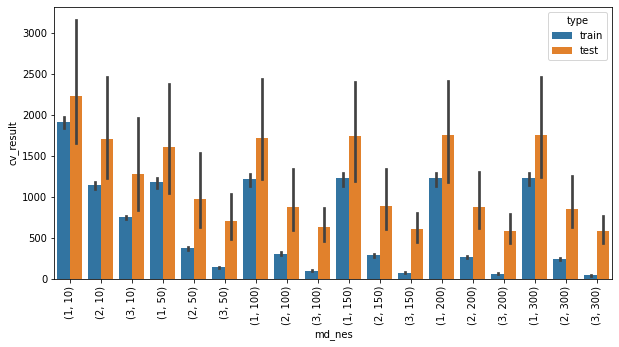

In [104]:
ax, fig  = plt.subplots(1,1,figsize = (10,5))
ax = sns.barplot(data=cv_gs_results , x =cv_gs_results["md_nes"] , y = "cv_result" ,hue = "type" )
ax.set_xticklabels(ax.get_xticklabels() ,rotation = 90);

In [105]:
df_plt = cv_gs_results.groupby(["md_nes", "type"],as_index=False).mean().drop(["max_depth" , "n_estimators"],axis=1)

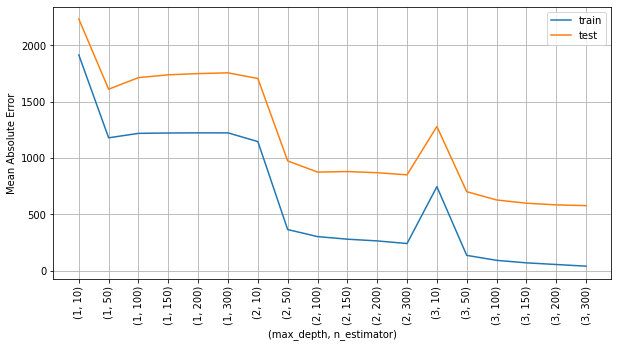

In [106]:
plt.figure(figsize=(10,5) )
plt.plot(list(map(str,df_plt[df_plt["type"] == "train"].md_nes.values)),  list(df_plt[df_plt["type"] == "train"].cv_result.values),label = "train")
plt.plot(list(map(str,df_plt[df_plt["type"] == "test"].md_nes.values)),  list(df_plt[df_plt["type"] == "test"].cv_result.values),label = "test")
plt.xticks(rotation = 90)
plt.xlabel("(max_depth, n_estimator)")
plt.ylabel("Mean Absolute Error")
plt.legend()
plt.grid(which = "both")

In [4]:
model_Energy= GradientBoostingRegressor( learning_rate=0.2, max_depth=3, n_estimators=150)
Energy = cross_validate(model_Energy,X_data,Y_data.reshape(-1,),cv=10,scoring=('neg_mean_absolute_error'),return_train_score=True)

In [5]:
print("test scores:\n",list(map(abs,Energy["test_score"])))
print("mean:  ",abs(np.mean(Energy["test_score"])) )
print("\n\n")
print("train scores:\n",list(map(abs,Energy["train_score"])))
print("mean:  ",abs(np.mean(Energy["train_score"]) ))


test scores:
 [330.4644591913421, 785.0462631369192, 585.7293043430138, 598.0997763160428, 367.61702777062106, 523.7048450764327, 581.8390389732247, 809.4903121972386, 287.6125425318484, 663.341141374905]
mean:   553.2944710911588



train scores:
 [79.12904851582323, 38.55154095522941, 49.763895348160794, 53.03665984185145, 87.31485842846276, 92.38022151039847, 57.78071355064567, 68.4045792684786, 57.84788276936983, 62.66347912439599]
mean:   64.68728793128162


In [6]:
model_Energy.fit(X_data, Y_data)

GradientBoostingRegressor(learning_rate=0.2, n_estimators=150)

In [7]:
from joblib import dump, load
dump(model_Energy,'model_Energy.h5') 

['model_Energy.h5']